In [2]:
import matplotlib 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import svm

import glob
import json
import pickle
import operator
import numpy as np
import seaborn as sns
from scipy import stats
sns.set(style="ticks")
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chisquare
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from pandas.tools.plotting import parallel_coordinates
import mpl_toolkits.axes_grid1 as axes_grid1
rcParams['mathtext.default'] = 'regular'
%matplotlib inline

print('Done')

Done


In [3]:
#Load-in H-chain data

at=['H']

dat_l=[]

suffix='iao'

spins=[0]

for meth in ['uks']:
  for type in ['singles', 'doubles']:
    for k in at:
        for s in spins:
            add=pd.read_pickle("Coeff_"+np.str(k)+"_dmc_"+np.str(suffix)+"_spin"+np.str(s)+"_"+np.str(type)+"_"+meth+".pkl")
            L=len(add['energy'])
            add['Method']=[meth for k in range(L)]
            add['Excitation']=[type for k in range(L)]
            dat_l.append(add)
            
for meth in ['rks']:
  for type in ['doubles']:
    for k in at:
        for s in spins:
            add=pd.read_pickle("Coeff_"+np.str(k)+"_dmc_"+np.str(suffix)+"_spin"+np.str(s)+"_"+np.str(type)+"_"+meth+".pkl")
            L=len(add['energy'])
            add['Method']=[meth for k in range(L)]
            add['Excitation']=[type for k in range(L)]
            dat_l.append(add)
            

dat = pd.concat(dat_l)

print(dat.keys())

evc=27.2114

Len=len(dat['atom'])
dat = dat.reset_index(drop=True)

L=len(dat['energy'])
#print(dat)

###############################################################################

dat.to_csv('H_chain_data.csv')
dat.to_pickle('H_chain_data.pkl')

act_num=10

print('Act. Pop. Cut-Off: '+np.str(act_num-0.5))
dat=dat[dat['Act. Pop.'] > act_num-0.5]
dat=dat[dat['Act. Pop.'] < act_num+0.05]
dat=dat[dat['energy'] > -5.1]
print(dat)

dat.to_csv('H_chain_data.csv')

print('')
print('Done')

Index([ u'Act. Pop.',   u'Constant',          u'J',     u'Length',
               u'Us',          u'V',         u'V2',         u'V3',
             u'atom',     u'energy',      u'error',     u'esterm',
       u'functional',       u'spin',          u't',     u'Method',
       u'Excitation'],
      dtype='object')
Act. Pop. Cut-Off: 9.5
     Act. Pop.  Constant         J Length        Us          V         V2  \
34    9.835792       1.0  0.634640   1.25  1.971939  10.405063  11.572415   
35    9.887172       1.0  0.590575   1.25  1.851671   9.640765  12.684135   
39    9.802331       1.0  0.710656   1.25  1.940599   9.951766  10.760087   
41    9.891224       1.0  0.591110   1.25  1.925259  10.341700  11.556263   
46    9.861755       1.0  0.819209   1.25  1.971267  10.683343  11.349117   
47    9.864617       1.0  0.687371   1.25  1.877224  10.339684  11.542253   
53    9.853497       1.0  0.788719   1.25  1.829226  10.582204  11.284529   
59    9.866154       1.0  0.869689   1.25  1.902

Done


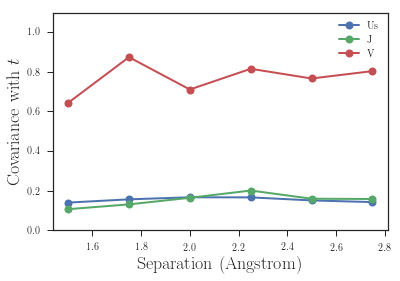

In [15]:
#Covariance of U/J/V with t as a function of Bond Length

L=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
DM_terms=['Us', 'J', 'V']

lw=0
fs=18
ms=8

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for i,p in enumerate(DM_terms):
    cov=[]
    for l in L:
        descrip=[]
        dat_L=dat[dat['Length'] == np.str(l)]
        for k in ['t',p]:
            descrip.append(dat_L[k])
        descrip_x = np.vstack(descrip)
        covt = np.cov(descrip_x)[0][1]
        cov.append(covt)
    plt.plot(L, np.abs(cov), linewidth=lw+2, marker='o', markersize=ms-2, mew=2, label=p)

plt.legend()
plt.xlabel('Separation (Angstrom)', fontsize=fs)
plt.ylabel('Covariance with $t$', fontsize=fs)
plt.ylim([0,1.1])
plt.savefig('t_covariance_vs_separation.pdf', bbox_inches='tight')
plt.savefig('t_covariance_vs_separation.png', bbox_inches='tight')


print('Done')

Done


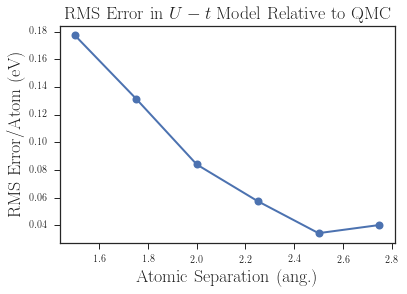

In [11]:
#Plot RMS error vs. bond length

Natom=10
from scipy.optimize import least_squares
evc=27.2114
func_choice='pbe'
#lengths=[1, 1.25, 1.5, 1.75, 2.0]
lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

def fun(parms, dum_descrip, E):
    nparm=len(parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=parms[k]*dum_descrip[l][k]
    return est-E

def mod_energy(fit_parms, dum_descrip):
    nparm=len(fit_parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=fit_parms[k]*dum_descrip[l][k]
    return est


filemod=''
parameters=['Constant', 't', 'Us']

param_hold=[[] for k in range(len(parameters)-1)]

rms_hold=[]


x0=[np.min(dat_func['energy'])]
for k in range(len(parameters)-1):
    parm_name=parameters[k+1]
    filemod+=np.str(parm_name)
    x0+=[0]

for ln in range(len(lengths)):
    plt.figure(ln)
    length=lengths[ln]
    dat_func=dat[ dat['Length']==np.str(length) ]
    descrip=np.zeros((len(dat_func['Constant']), len(parameters)))
    for i,p in enumerate(parameters):
        descrip[:,i]=np.array(dat_func[p])

    ab_energy=evc*dat_func['energy']
    ab_err=evc*dat_func['error']

    res_lin = least_squares(fun, x0, loss='linear', args=(descrip, ab_energy))
    model_energy = mod_energy(res_lin.x, descrip)
    
    resid=ab_energy-model_energy
    resid=np.array(resid)
    rms=np.sqrt(np.sum(resid**2)/len(resid))

    lw=0
    fs=18
    ms=8
        
    rms_hold.append(rms)
        
    for n in range(len(parameters)-1):
      param_hold[n].append(res_lin.x[n+1])

c=1

plt.figure(c)
c+=1
plt.plot(lengths, np.array(rms_hold)/Natom, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
plt.ylabel('RMS Error/Atom (eV)', fontsize=fs)
plt.title('RMS Error in $U-t$ Model Relative to QMC', fontsize=fs)
plt.savefig('rms_ut_error_vs_separation_h_chain.pdf', bbox_inches='tight')
plt.savefig('rms_ut_error_vs_separation_h_chain.png', bbox_inches='tight')

print('Done')

Done


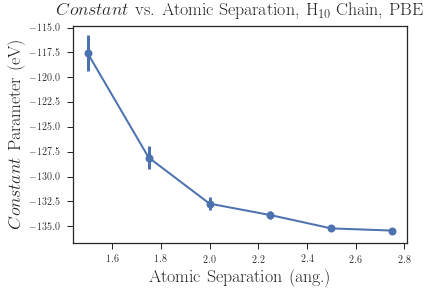

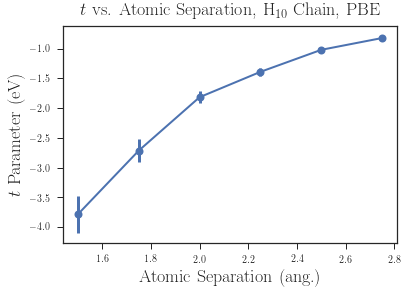

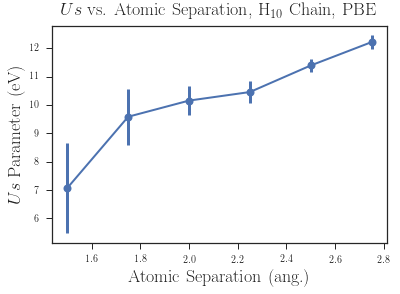

In [13]:
#Use OLS package to get parameter errors

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
evc=27.2114

def fit_dataframe(parameters,df):
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])
  x,res,rank,s=np.linalg.lstsq(A,K)
  K_mod=np.dot(A,x)
  Kerr=np.array(df['error'])
  return x,res,K,Kerr,K_mod  

def fit_dataframe_ols(parameters,df):
  evc=27.2114
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])*evc

  model=sm.OLS(K,A).fit()
  results = model
#  print(results.summary())
  
  return model,A,K  


#(x[0][cc]*evc, mod.bse[cc])

DM_terms=['Constant', 't', 'Us']

params={}
for p in DM_terms:
    params[p]={'Value':[], 'Error':[]}

lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

for il,l in enumerate(lengths):
    dat_L=dat_func[ dat_func['Length']==np.str(l) ]
    x=fit_dataframe(DM_terms,dat_L)
    mod,X,Y=fit_dataframe_ols(DM_terms,dat_L)
    E_ab=x[2]
    E_err=x[3]
    E_mod=x[4]
    E_err_mod=(np.array(E_ab)-np.array(E_mod))
    for iv,v in enumerate(x[0]):
        params[DM_terms[iv]]['Value'].append(v)
        params[DM_terms[iv]]['Error'].append(mod.bse[iv])
    
c=1
for i,p in enumerate(DM_terms):
      plt.figure(c)
      c+=1
      plt.errorbar(lengths, evc*np.array(params[p]['Value']), yerr=np.array(params[p]['Error']), elinewidth=3, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
      plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
      plt.ylabel('$'+np.str(p)+'$ Parameter (eV)', fontsize=fs)
      plt.title('$'+np.str(p)+'$ vs. Atomic Separation, H$_{10}$ Chain, PBE', fontsize=fs)
      plt.savefig('$'+np.str(p)+'$_vs_separation_h_chain_ols.pdf', bbox_inches='tight')
      plt.savefig('$'+np.str(p)+'$_vs_separation_h_chain_ols.png', bbox_inches='tight')


print('Done')

Done


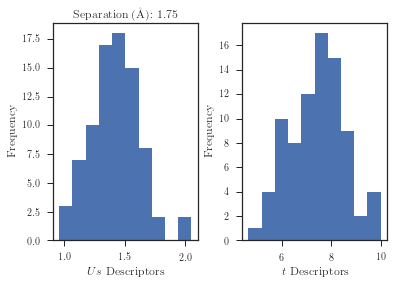

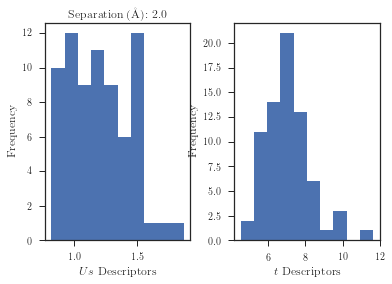

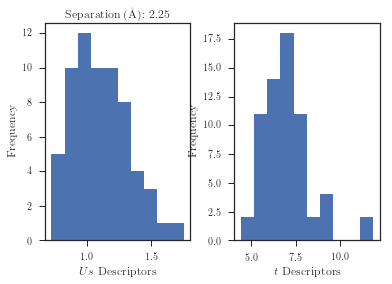

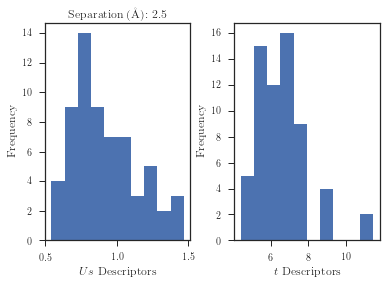

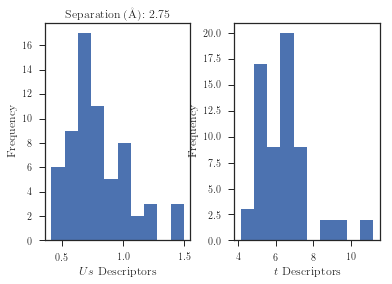

In [17]:
#Histograms of parameter distributions

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

DM_terms=['Us', 't']
functionals_list=[ 'pbe']
spins=['Spin: 0', 'Spin: 1', 'Spin: 2']
#lengths_list=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
lengths_list=[1.75, 2.0, 2.25, 2.5, 2.75]

func=functionals_list[0]

spin_choice='Spin: 0'

dat_copy=dat.copy()
dat_copy=dat_copy[dat_copy['spin']==spin_choice]

at_name=at[0]

lw=0
fs=12
ms=8
bn=10

#Spin0_length175_pbe_H_relation.pdf

c=1
for l in lengths_list:
    dater1=dat_copy[dat_copy['Length']==np.str(l)]
    dater1 = dater1.reset_index(drop=True)
    
    energies=dater1['energy']
    a=dater1.hist(column=DM_terms, bins=bn, grid=False)
    for i,p in enumerate(DM_terms):
      a[0][i].set_ylabel('Frequency', fontsize=fs)
      a[0][i].set_xlabel('$'+p+'$ Descriptors', fontsize=fs)
    
    a[0][0].set_title(r'Separation (\AA): '+np.str(l), fontsize=fs)
    a[0][1].set_title('', fontsize=fs)

    plt.savefig('Spin0_'+np.str(func)+'_length'+np.str(l)+'_'+np.str(at_name)+'_relation.pdf', bbox_inches='tight')
    plt.savefig('Spin0_'+np.str(func)+'_length'+np.str(l)+'_'+np.str(at_name)+'_relation.png', bbox_inches='tight')

    c+=1
    plt.figure(c)
        
print('Done')